# CS4487 Course Project: Aerial Cactus Identification

GAO Ya (55199949)

ZHOU Zhiyu (55003367)

## Table of Contents

* [1. Introduction](#chapter1)
* [2. Objective](#chapter2)
* [3. Data Description](#chapter3)
* [4. Data Representation Methodology](#chapter4)
    * [4.1 Normalization](#section_4_1)
    * [4.2 Feature Extraction](#section_4_2)
    * [4.3 Dimensionality Reduction](#section_4_3)
* [5. Model](#chapter5)
  * [5.1 Random Forest](#section_5_1)
  * [5.2 Naive Bayes](#section_5_2)
  * [5.3 Convolutional Neural Network](#section_5_3)
* [6. Comparison](#chapter6)
* [7. Conclusion](#chapter7)
* [8. Reference](#chapter8)
* [9. Appendix](#chapter9)

Remark: Submission on Kaggle is based on CNN （5.3 only)

## 1. Introduction <a id="chapter1"></a>

Because of the climate change, the flora of Earth, including cactus, has been impacted. Building up an autonomous surveillance system for the protected areas is an vital step to make an assessment of the impact, which the VIGIA project aims doing. Following the project instructions and making use of the provided dataset from Kaggle, we are able to make use of the knowledge we learned from class and out of class, design and conduct multiple experiments using different algorithms and techniques, train and test the models, and selecting the models with best performances.

Experiments has been conducted using the KNN, Naive-Bayes, Linear Discriminant, Support Vector Machine, Logistic Regression, Random Forest, and Convolutional Neural Network. For the first six models, multiple tests has been included to see the performance of adding techniques like normalization, feature-extraction and/or dimensionality reduction techniques, including Principal Component Analysis, Singular Value Decomposition, Kernel Principal Component Analysis, and Independent Component Analysis.

To save time and improve efficiency, we divided the tasks equally and then tested the whole program of the traditional techniques. After presenting our progress in class, we realized the necessity of involving CNN for better performance and higher testing accuracy.

## 2. Objective <a id="chapter2"></a>

From the nature of our dataset, it is easy to observe that this is a binary classification task. Our goal is to find models that can tell whether the image contains cactus or not. Such a goal is achieved by indicating the label of a given input image. Every input image should be in one of the two classes, one for cactus, and another for no-cactus. Therefore, this classification task is binary. 

In our preliminary experiments, we have trained and tested different combinations of input data: raw data, normalized data, feature-extracted data, and normalized feature-extracted data, with the above-mentioned six traditional models. Through these tests, we are able to see the changes in accuracy and running time, and select those models with best performance. We also applied CNN after testing all the traditional approaches, trying to improve the performance.

In this report, to present the testing result and make the main body clearer, only the three chosen models which are having top accuracies, Naive-Bayes, Random Forest, and the CNN, have been presented in part 5. The others, which we have also conducted experiments but turned out to be less accurate, are attached in the Appendix at the end of this file.

## 3. Data Description <a id="chapter3"></a>

First of all, we need to initialize python.

In [1]:
from numpy.random import seed
seed(4487)

%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")

# general lib
import matplotlib
import matplotlib.pyplot as plt
from numpy import *

# data extraction
import os
import zipfile
import fnmatch
from scipy import ndimage
from scipy import signal
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
from skimage.transform import resize

# machine learning libs
from sklearn import *
from sklearn.ensemble import *
import sklearn.model_selection

# libs for result ananlysis
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# libs for CNN model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam

Then we load the data from the dataset. For all of the traditional methods we applied, cross-validation has been used in training. Therefore, the training set is the oringinal set as provided, which contains 17,500 images, and 13,136 of them contain cactus. The dataset is imbalanced. The testing set is the oringinal validation set, which contains 4,000 images.

Another thing we noticed when loading data is that the images in the dataset are of different size. Therefore, resizing is always necessary, and we also did the same for the data for CNN.

To resize the images, the choice of the size needs to be carefully considered. Because of the fact that all of the images having no cactus are of size 32 by 32, we resize all images to 32 by 32 when loading. 

The analysis on dataset imbalance and the statistic on no-cactus image size has been attached at the end of this section.

In real practice, we need to denote the path of the dataset in slightly different way for Mac and Windows. Otherwise the loading fails. Below shows the case for mac. For Windows, the path need to be changed to "training_set/*/*/*.jpg". 

In [2]:
# for mac
imgdata_X = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}
dim_no_cactus = []

# load the zip file
filename = 'data.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "data/training_set/training_set/*/*.jpg"):
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (cactus, no_cactus)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = cactus; class 0 = no cactus
        myclass = int(fclass == "cactus")  
        
        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        
        if (myclass == 0):
            dim_no_cactus.append(img.shape)
        # convert to grayscale
        img = skimage.color.rgb2gray(img)
        img = resize(img, (32, 32), preserve_range=True, anti_aliasing=True)
        myfile.close()

        # append data
        imgdata_X['train'].append(img)
        classes['train'].append(myclass)
        
    elif fnmatch.fnmatch(name, "data/validation_set/validation_set/*/*.jpg"):
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (cactus, no_cactus)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        
        myclass = int(fclass == "cactus")  

        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        if (myclass == 0):
            dim_no_cactus.append(img.shape)

        # convert to grayscale
        img = skimage.color.rgb2gray(img)
        img = resize(img, (32, 32), preserve_range=True, anti_aliasing=True)
        myfile.close()

        # append data
        imgdata_X['test'].append(img)
        classes['test'].append(myclass)
        
zfile.close()
imgsize = img.shape

print(len(imgdata_X['train']))
print(len(imgdata_X['test']))
trainclass2start = sum(classes['train'])

17500
4000


As shown in the codes, the class lable is 1 when the image belongs to the folder 'cactus', and 0 if it is in 'no_cactus'.

Here we plot some examples for image with cactus and image with no cactus, and make an image montage.

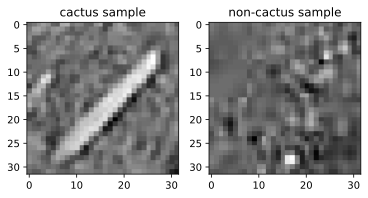

In [3]:
plt.subplot(1,2,1)
plt.imshow(imgdata_X['train'][0], cmap='gray', interpolation='nearest')
plt.title("cactus sample")
plt.subplot(1,2,2)
plt.imshow(imgdata_X['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-cactus sample")
plt.show()

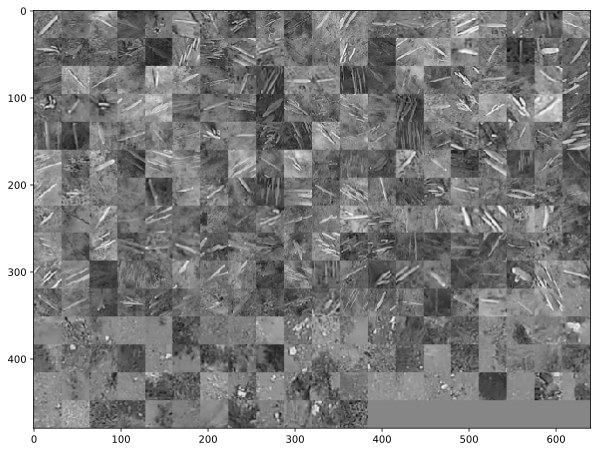

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=20):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(10,10))
plt.imshow(image_montage(imgdata_X['train'][::60]), cmap='gray', interpolation='nearest')
plt.show()

And then create the training and testing sets.

In [5]:
trainX = empty((len(imgdata_X['train']), prod(imgsize)))
for i,img in enumerate(imgdata_X['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print(trainX.shape)
print(trainY.shape)

testX = empty((len(imgdata_X['test']), prod(imgsize)))
for i,img in enumerate(imgdata_X['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print(testX.shape)
print(testY.shape)

(17500, 1024)
(17500,)
(4000, 1024)
(4000,)


Similarly, we load and convert the data for Convolutional Neural Network, and plot samples images. This has to be done seperately as the model has specific requirements for data. For CNN, we should not convert the images into grayscale. 

The testing set for CNN is the same as the oringinal validation set. 20% of the oringinal training set will be splitted as our validation set, while the remaining 80% takes the role of our training set. This will be specified in section 5.3.

In [6]:
# for mac
imgdata_NN = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# load the zip file
filename = 'data.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "data/training_set/training_set/*/*.jpg"):
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (cactus, no_cactus)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = cactus; class 0 = no cactus
        myclass = int(fclass == "cactus")       
        
        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        img = resize(img, (32, 32, 3), preserve_range=True, anti_aliasing=True)
        myfile.close()

        # append data
        imgdata_NN['train'].append(img)
        classes['train'].append(myclass)
        
    elif fnmatch.fnmatch(name, "data/validation_set/validation_set/*/*.jpg"):
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (cactus, no_cactus)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        
        myclass = int(fclass == "cactus")  

        myfile = zfile.open(name)

        img = matplotlib.image.imread(myfile)
        img = resize(img, (32, 32, 3), preserve_range=True, anti_aliasing=True)
        myfile.close()

        # append data
        imgdata_NN['test'].append(img)
        classes['test'].append(myclass)
        
zfile.close()
imgsize2 = img.shape

print(len(imgdata_NN['train']))
print(len(imgdata_NN['test']))
trainclass2start = sum(classes['train'])

17500
4000


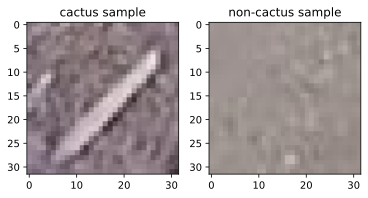

In [7]:
plt.subplot(1,2,1)
plt.imshow(imgdata_NN['train'][0].astype('uint8'), interpolation='nearest')
plt.title("cactus sample")
plt.subplot(1,2,2)
plt.imshow(imgdata_NN['train'][trainclass2start].astype('uint8'), interpolation='nearest')
plt.title("non-cactus sample")
plt.show()

In [8]:
trainX_NN = empty((len(imgdata_NN['train']), prod(imgsize2)))
for i,img in enumerate(imgdata_NN['train']):
    trainX_NN[i,:] = ravel(img)
print(trainX_NN.shape)
print(trainY.shape)

testX_NN = empty((len(imgdata_NN['test']), prod(imgsize2)))
for i,img in enumerate(imgdata_NN['test']):
    testX_NN[i,:] = ravel(img)
print(testX_NN.shape)
print(testY.shape)

(17500, 3072)
(17500,)
(4000, 3072)
(4000,)


#### Class imbalance analysis

We plot the number of images in the two classes of training_set. In the set, around 25% images are containing no cactus, while about 75% contain cactus. This shows an imbalance between classes.

Text(0.5, 1.0, 'Class imbalance')

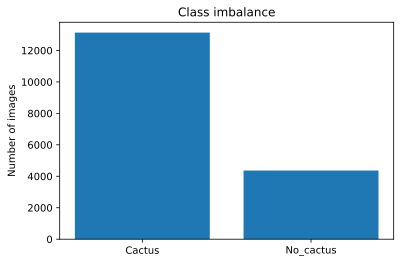

In [9]:
c = ('Cactus', 'No_cactus')
y_pos = arange(len(c))
cactus_total = [x for x in classes['train'] if x==1]
no_cactus_total = [x for x in classes['train'] if x==0]
number = [len(cactus_total), len(no_cactus_total)]

plt.bar(y_pos, number, align='center')
plt.xticks(y_pos, c)
plt.ylabel('Number of images')
plt.title('Class imbalance')


#### No-cactus image size analysis

Below we show that all no-cactus images are of the same size: 32 by 32. By this result, we chose to resize all images to this dimension. Actually we also conducted an expeirment classifying all images of size 32 by 32 in the testing set as no-cactus, receiving accuracy around 96%.

In [10]:
count = 0
for d in dim_no_cactus:
    if d == (32,32, 3):
        count+=1
print(f'Number of no-cactus images with dim (32, 32): {count}')
print(f'Total number of no_cactus images:   {len(dim_no_cactus)}')

Number of no-cactus images with dim (32, 32): 5364
Total number of no_cactus images:   5364


## 4. Data Representation Methodology <a id="chapter4"></a>

Data can be represented in various format. Different representations can cause different results in the model performance. In this project, we applied three methods to transform our raw data, which are normalization, feature extraction and dimensionality reduction.

### 4.1 Normalization <a id="section_4_1"></a>

The goal of the normalization is to apply a common scale to the dataset without losing information. Because the flattened arrays for each image in our dataset has different value ranges, normalization is required for us when we implement some algorithms, for example, convolutional neural network. The technique we implemented is the MinMaxScaler. It is used to trasnform the given feature into a value bounded by min-max scale predefined by the user. For this project, we scaled the training X and testing X data into a min-max bound of (-1, 1). Below are the code for this operation.

In [11]:
# Normalize data
def norm(trainX, testX):
    scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
    trainXnm = scalerf.fit_transform(trainX)   # use training data to fit scaling parameters
    testXnm  = scalerf.transform(testX)        # apply scaling to test data
    return trainXnm, testXnm

In [12]:
# Normalized data for experiment
trainXn, testXn = norm(trainX, testX)
trainXn_NN, testXn_NN = norm(trainX_NN, testX_NN)

### 4.2 Feature Extraction <a id="section_4_2"></a>

Feature extraction can help the classifiers to take larger structure of the image into consideration. As the pixel data only represent a tiny part of the whole picture, classification based on this data can overlook distinct characteristics, for example, in facial recognition, the nose, mouth, and eyes are important features. In our project, we have used the same method introduced in the tutorial - filtering, to extract features. The filters are  sets of black and white boxes that respond to similar structures in the image. After applying the filters to the image, the filter response map is aggregated over a 4x4 window. Hence each filter produces a 8x8 feature response. Since there are 4 filters, then the feature vector is 256 dimensions. The detailed codes are shown below.

In [13]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

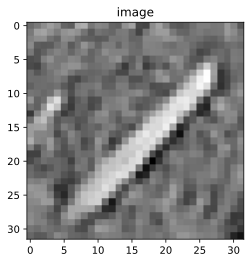

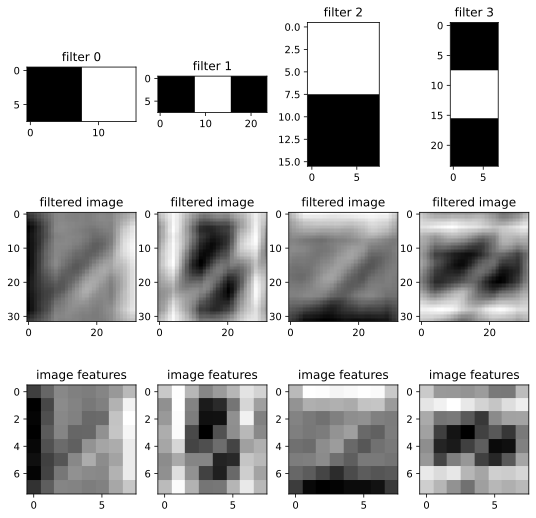

In [14]:
# new features
img = imgdata_X['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

In [15]:
# Feature extraction on raw data
trainXf = extract_features(imgdata_X['train'])
print(trainXf.shape)
testXf = extract_features(imgdata_X['test'])
print(testXf.shape)

(17500, 256)
(4000, 256)


In [16]:
# Normalization on feature extracted data
trainXfn, testXfn = norm(trainXf, testXf)

### 4.3 Dimensionality Reduction <a id="section_4_3"></a>

Since our data dimension is relatively large, it is reasonable to apply some dimensionality reduction algorithms on our data. We applied four techniques, which are PCA (Principal Component Analysis), SVD (Singular Value Decomposition), KPCA (Kernel PCA), and ICA (Independent Component Analysis). Since the number of components to be included in each method is a crucial parameter for the final model performance, we have customized different ranges of number for different classifiers. The specific values are defined in the model section. The goal for creating such a list is to select the one that yields the highest testing accuracy among all others.

#### 4.3.1 PCA

Principal Component Analysis is an unsupervised linear method that can be used to reduce the dimension of the data. The goal for the technique is to find the maximum variance directions inside the dataset. It will choose some basis vectors (principal components) along the direction of maximum variance in the original space, and project the data into subspace based on these vectors. <br>
There are two limitations of PCA. 1) Decorrelation. Since PCA remove the 2nd-order dependencies, the relationship between the feature in higher dimensions maybe overlooked. 2) Perpendicular components. As PCA require each basis vectors to be orthogonal to each other, data that are distributed in axes not perpendicular to each other may not be properly tackled with PCA. 

In [17]:
# function for using PCA
def pca_func(trainX, testX, trainY, testY, model):
    testacc = []
    for i in ns:
        pca = decomposition.PCA(n_components = i).fit(trainX)
        trainXn = pca.transform(trainX)
        testXn = pca.transform(testX)
        m = model.fit(trainXn, trainY)
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return testacc

#### 4.3.2 SVD

Singular Value Decomposition is another linear dimensionality reduction algorithm. It literally produces the same result as PCA, but with different calculations as discussed in the lecture. 

In [18]:
# function for using SVD
def svd_func(trainX, testX, trainY, testY, model):
    testacc = []
    for i in ns:
        svd = decomposition.TruncatedSVD(n_components=i).fit(trainX)
        trainXn = svd.transform(trainX)
        testXn = svd.transform(testX)
        m = model.fit(trainXn, trainY)
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return testacc

#### 4.3.3 KPCA

Kernel PCA is to implement PCA with kernel tricks. It allows non-linear data distribution which relieve some restrictions of PCA. When using different kernel functions, the data in the original space is being projected to the new subspace based on the chosen kernel function. In this project, we implemented two types of kernel, which are RBF (Radial Basis Function) and Polynomial. The two functions for applying kernel PCA are shown below.

In [19]:
def kpca_rbf_func(trainX, testX, trainY, testY, model):
    testacc = []
    for i in ns:
        kpca = decomposition.KernelPCA(n_components=i, kernel='rbf',n_jobs=-1).fit(trainX)
        trainXn = kpca.transform(trainX)
        testXn = kpca.transform(testX)
        m = model.fit(trainXn, trainY)
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return testacc

def kpca_poly_func(trainX, testX, trainY, testY, model):
    testacc = []
    for i in ns:
        kpca = decomposition.KernelPCA(n_components=i, kernel='poly',n_jobs=-1).fit(trainX)
        trainXn = kpca.transform(trainX)
        testXn = kpca.transform(testX)
        m = model.fit(trainXn, trainY)
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return testacc

#### 4.3.4 ICA

Independent Component Analysis is a technique to de-mix or de-noise the data containing multiple sources. The way ICA achieve its goal is to find non-Gaussian and statistically independent basis vectors. Moreover, when the number of sources is the same as the number of observed linearly mixed channels, it is a source separation problem. When the former is less than the latter, the problem tackled by the algorithm is the dimensionality reduction. <br>
For our problem, we applied the algorithm as a way to reduce the data complexity and increase the efficiency in processing time. The implementation is shown as below.

In [20]:
def ica_func(trainX, testX, trainY, testY, model):
    testacc = []
    for i in ns:
        ica = decomposition.FastICA(n_components=i).fit(trainX)
        trainXn = ica.transform(trainX)
        testXn = ica.transform(testX)
        m = model.fit(trainXn, trainY)
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return testacc

## 5. Model <a id="chapter5"></a>

After obtaining the structured data with different techniques to be considered, we started to build our models. In our preliminary experiment, we applied many traditional models including LDA, Naive Bayes, K-nearest Neighbour, Logistic Regression and SVM. For a better analysis, we chose two of the above-mentioned models, Random Forest and Naive Bayes, as our base models. This choice is based on their performance in the preliminary experiments. They yield higher accuracy in their group of models, discriminative classifiers and generative classifiers, respectively. On the other hand, we have also implemented a transfer learning method - ResNet50 in our preliminary experiment. However, we latter self-constructed a better CNN which outperform the pre-trained ResNet50. All base models and CNN model will be analyzed in detail in this report, while other models are placed in the appendix.

### 5.1 Random Forest <a id="section_5_1"></a>

#### 5.1.1 Model description

Random Forest is an ensemble learning method which can be applied to various tasks, for example, classification and regression. The method is implemented by constructing many decision trees in the training process and select the majority voting of the class output when testing. There are many hyperparameters for the Random Forest Classifier. For instance, max_depth suggests the maximum depth of the tree; n_estimators indicates the number of trees in the forest; criterion implies the measure used to assess the quality of split, and there are two criterion - Gini impurity (gini) and Information gain (entropy); the default type is the gini. In our implementation, we fixed the hyperparameters to a specific value because the tunning process took excessively long time.

In [42]:
def RF():
    return RandomForestClassifier(random_state = 4487, max_depth = 15, n_estimators = 500)

#### 5.1.2 Model implementation

We first implement the model using different data representations and without dimensionality reduction.

In [43]:
rf = RF().fit(trainX, trainY)
pred_rf = rf.predict(testX)
testAcc_rf = metrics.accuracy_score(testY, pred_rf)
print(f'Accuracy for raw data:                          {testAcc_rf}')

nrf = RF().fit(trainXn, trainY)
pred_nrf = nrf.predict(testXn)
testAcc_nrf = metrics.accuracy_score(testY, pred_nrf)
print(f'Accuracy for normalized raw data:               {testAcc_nrf}')

frf = RF().fit(trainXf, trainY)
pred_frf = frf.predict(testXf)
testAcc_frf = metrics.accuracy_score(testY, pred_frf)
print(f'Accuracy for feature extracted data:            {testAcc_frf}')

nfrf = RF().fit(trainXfn, trainY)
pred_nfrf = nfrf.predict(testXfn)
testAcc_nfrf = metrics.accuracy_score(testY, pred_nfrf)
print(f'Accuracy for normalized feature extracted data: {testAcc_nfrf}')

Accuracy for raw data:                          0.87975
Accuracy for normalized raw data:               0.88
Accuracy for feature extracted data:            0.86
Accuracy for normalized feature extracted data: 0.8595


As we can see from the tesing accuracy, **random forest with normalized data** performs the best with **0.88** accuracy. Next, we apply each dimensionality reduction technique on each of the data representations for this model and see whether the result will be improved.

Here we define the set of number of components for cross-validation of Random Forest. Since in lecture we learnt that the performance usually becomes stable when the number of components is larger than 20, and the processing time is really long on this model, we chose a smaller set of number of components here.

In [44]:
ns = [20,25,30]

In [45]:
# raw data
testacc_rf_pca = pca_func(trainX, testX, trainY, testY, RF())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_rf_pca.index(max(testacc_rf_pca))]}')
print(f'Best test accuracy: {max(testacc_rf_pca)}')

testacc_rf_svd = svd_func(trainX, testX, trainY, testY, RF())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_rf_svd.index(max(testacc_rf_svd))]}')
print(f'Best test accuracy: {max(testacc_rf_svd)}')

testacc_rf_kpca_rbf = kpca_rbf_func(trainX, testX, trainY, testY, RF())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_rf_kpca_rbf.index(max(testacc_rf_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_rf_kpca_rbf)}')

testacc_rf_kpca_poly = kpca_poly_func(trainX, testX, trainY, testY, RF())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_rf_kpca_poly.index(max(testacc_rf_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_rf_kpca_poly)}')

testacc_rf_ica = ica_func(trainX, testX, trainY, testY, RF())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_rf_ica.index(max(testacc_rf_ica))]}')
print(f'Best test accuracy: {max(testacc_rf_ica)}')

----------PCA----------
Best number of components: 30
Best test accuracy: 0.85475
----------SVD----------
Best number of components: 30
Best test accuracy: 0.854
----------KPCA_rbf----------
Best number of components: 30
Best test accuracy: 0.85875
----------KPCA_poly----------
Best number of components: 30
Best test accuracy: 0.85725
----------ICA----------
Best number of components: 30
Best test accuracy: 0.857


In [46]:
# normalized data
testacc_nrf_pca = pca_func(trainXn, testXn, trainY, testY, RF())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_nrf_pca.index(max(testacc_nrf_pca))]}')
print(f'Best test accuracy: {max(testacc_nrf_pca)}')

testacc_nrf_svd = svd_func(trainXn, testXn, trainY, testY, RF())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_nrf_svd.index(max(testacc_nrf_svd))]}')
print(f'Best test accuracy: {max(testacc_nrf_svd)}')

testacc_nrf_kpca_rbf = kpca_rbf_func(trainXn, testXn, trainY, testY, RF())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_nrf_kpca_rbf.index(max(testacc_nrf_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_nrf_kpca_rbf)}')

testacc_nrf_kpca_poly = kpca_poly_func(trainXn, testXn, trainY, testY, RF())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_nrf_kpca_poly.index(max(testacc_nrf_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_nrf_kpca_poly)}')

testacc_nrf_ica = ica_func(trainXn, testXn, trainY, testY, RF())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_nrf_ica.index(max(testacc_nrf_ica))]}')
print(f'Best test accuracy: {max(testacc_nrf_ica)}')

----------PCA----------
Best number of components: 30
Best test accuracy: 0.855
----------SVD----------
Best number of components: 30
Best test accuracy: 0.8555
----------KPCA_rbf----------
Best number of components: 25
Best test accuracy: 0.8565
----------KPCA_poly----------
Best number of components: 30
Best test accuracy: 0.85575
----------ICA----------
Best number of components: 25
Best test accuracy: 0.856


In [47]:
# feature extraction data
testacc_frf_pca = pca_func(trainXf, testXf, trainY, testY, RF())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_frf_pca.index(max(testacc_frf_pca))]}')
print(f'Best test accuracy: {max(testacc_frf_pca)}')

testacc_frf_svd = svd_func(trainXf, testXf, trainY, testY, RF())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_frf_svd.index(max(testacc_frf_svd))]}')
print(f'Best test accuracy: {max(testacc_frf_svd)}')

testacc_frf_kpca_rbf = kpca_rbf_func(trainXf, testXf, trainY, testY, RF())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_frf_kpca_rbf.index(max(testacc_frf_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_frf_kpca_rbf)}')

testacc_frf_kpca_poly = kpca_poly_func(trainXf, testXf, trainY, testY, RF())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_frf_kpca_poly.index(max(testacc_frf_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_frf_kpca_poly)}')

testacc_frf_ica = ica_func(trainXf, testXf, trainY, testY, RF())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_frf_ica.index(max(testacc_frf_ica))]}')
print(f'Best test accuracy: {max(testacc_frf_ica)}')

----------PCA----------
Best number of components: 25
Best test accuracy: 0.84275
----------SVD----------
Best number of components: 25
Best test accuracy: 0.846
----------KPCA_rbf----------
Best number of components: 30
Best test accuracy: 0.85225
----------KPCA_poly----------
Best number of components: 30
Best test accuracy: 0.8425
----------ICA----------
Best number of components: 20
Best test accuracy: 0.848


In [48]:
# normalized feature extraction data
testacc_nfrf_pca = pca_func(trainXfn, testXfn, trainY, testY, RF())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_nfrf_pca.index(max(testacc_nfrf_pca))]}')
print(f'Best test accuracy: {max(testacc_nfrf_pca)}')

testacc_nfrf_svd = svd_func(trainXfn, testXfn, trainY, testY, RF())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_nfrf_svd.index(max(testacc_nfrf_svd))]}')
print(f'Best test accuracy: {max(testacc_nfrf_svd)}')

testacc_nfrf_kpca_rbf = kpca_rbf_func(trainXfn, testXfn, trainY, testY, RF())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_nfrf_kpca_rbf.index(max(testacc_nfrf_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_nfrf_kpca_rbf)}')

testacc_nfrf_kpca_poly = kpca_poly_func(trainXfn, testXfn, trainY, testY, RF())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_nfrf_kpca_poly.index(max(testacc_nfrf_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_nfrf_kpca_poly)}')

testacc_nfrf_ica = ica_func(trainXfn, testXfn, trainY, testY, RF())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_nfrf_ica.index(max(testacc_nfrf_ica))]}')
print(f'Best test accuracy: {max(testacc_nfrf_ica)}')

----------PCA----------
Best number of components: 20
Best test accuracy: 0.84025
----------SVD----------
Best number of components: 30
Best test accuracy: 0.84175
----------KPCA_rbf----------
Best number of components: 20
Best test accuracy: 0.841
----------KPCA_poly----------
Best number of components: 20
Best test accuracy: 0.8445
----------ICA----------
Best number of components: 20
Best test accuracy: 0.84625


From the above result, the **random forest with KPCA_RBF kernel on raw data with 30 components** yields the best testing accuracy of **0.85875**. However, when compared to the accuracies obtained from the model without dimensionality reduction, the best testing accuracy among all models is **0.88** from **random forest with normalized data**.

#### 5.1.3 Result ananlysis

In this section, we will analyse the random forest classifier with the highest testing accuracy in detail. The model is random forest classifier with raw data. First, we plot the confusion matrix to see the prediction statistics of this model.

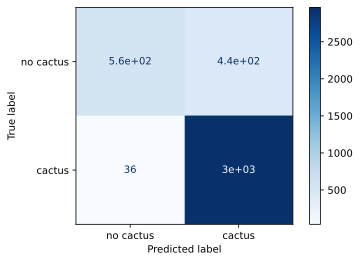

In [49]:
plot_confusion_matrix(nrf, testXn, testY, display_labels=['no cactus', 'cactus'], cmap=plt.cm.Blues,
values_format = 'd')

As you can see in the above confusion matrix plot, a significant portion of no cactus data has been classified incorrectly as cactus data. The FPR is around 44.4%. On the other hand, the TPR is around 98.8%. This suggests that the random forest classifier with normalized data have a reasonable ability of classifying cactus images but bad performance on no cactus images. The possible explanation for this situation can be the imbalance of cactus and no cactus images inside the training set. 

Then, we will visualize those pictures classified wrongly by the classifier.

Text(0.5, 1.0, 'misclassified images')

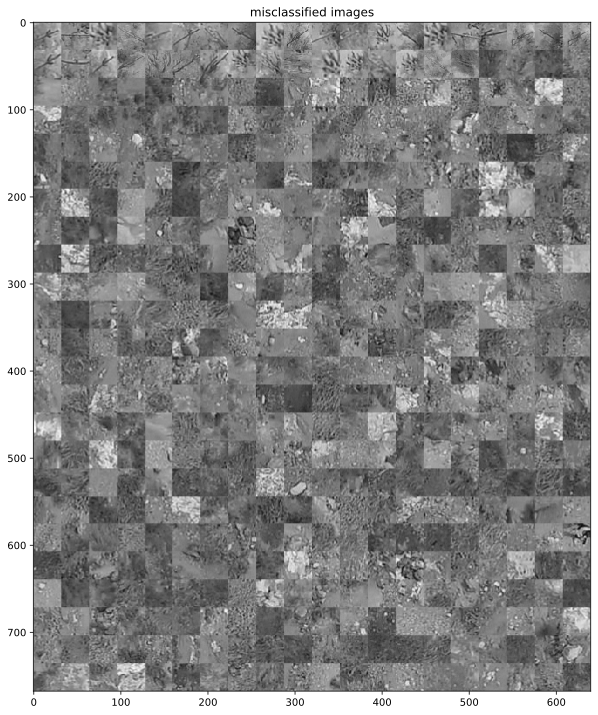

In [50]:
# find misclassified test images
inds = where(pred_nrf != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testXn[inds], imsize = imgsize)

# find correctly classified test images
inds = where(pred_nrf == testY)
goodimgs = image_montage(testXn[inds], imsize = imgsize)
    
plt.figure(figsize=(10,15))
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified images')

From the plot, there is no standout characteristics for the misclassification. Especially for no cactus images classified incorrectly, some are brighter some are darker. However, for the cactus images being classified as no cactus, they are all quite obvious from human eye that they are cactus; though some of the pictures are blur, it is hard to think of the reason for the classification mistake.

### 5.2 Naive Bayes <a id="section_5_2"></a>

#### 5.2.1 Model description

The second model we choose from the preliminary testing results is Naive-Bayes. It approximates the Bayes optimal classifier, assuming all feature dimensions being statistically independent. With Naive Bayes, we are able to observe and obtain the class label with highest probability.

In [21]:
def NB():
    paramgrid = {'alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0,5.0,10.0]}
    clf = model_selection.GridSearchCV(naive_bayes.BernoulliNB(), param_grid=paramgrid, cv=10, n_jobs=-1)
    return clf

#### 5.2.2 Model implementation

We first implement the model using different data representations and without dimensionality reduction.

For reducing the running time, the set ns has been set to a small range for Random Forest. Therefore, we need to firstly re-difine ns before starting training and testing. For Naive Bayes, the cross-validation has been done through a larger range, with elements of ns starting from 1 and ending at 90.

In [22]:
ns = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

In [23]:
nb = NB().fit(trainX,trainY)
pred_nb = nb.predict(testX)
print(f'Accuracy for raw data: {nb.score(testX,testY)}')

nnb = NB().fit(trainXn,trainY)
pred_nnb = nnb.predict(testXn)
print(f'Accuracy for normalized data: {nnb.score(testXn,testY)}')

fnb = NB().fit(trainXf,trainY)
pred_fnb = fnb.predict(testXf)
print(f'Accuracy for feature extraction data: {fnb.score(testXf,testY)}')

nfnb = NB().fit(trainXfn,trainY)
pred_nfnb = nfnb.predict(testXfn)
print(f'Accuracy for normalized feature extraction data: {nfnb.score(testXfn,testY)}')

Accuracy for raw data: 0.75
Accuracy for normalized data: 0.85825
Accuracy for feature extraction data: 0.71025
Accuracy for normalized feature extraction data: 0.87225


The highest testing accuracy of NB (with and without dimensionality reduction) has been reached here, **0.87225**, by the **normalized feature-extracted data**. It is slightly lower that that of Random Forest, but the difference is not big.

Now train and test Naive Bayes while applying the Dimensionality Reduction techniques. Similarly, the experiment has been conducted on the four different types of data: raw data, normalized data, feature-extracted data, and normalized feature-extracted data, as shown in the following blocks, respectively.

In [24]:
# raw data
testacc_nb_pca = pca_func(trainX, testX, trainY, testY, NB())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_nb_pca.index(max(testacc_nb_pca))]}')
print(f'Best test accuracy: {max(testacc_nb_pca)}')

testacc_nb_svd = svd_func(trainX, testX, trainY, testY, NB())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_nb_svd.index(max(testacc_nb_svd))]}')
print(f'Best test accuracy: {max(testacc_nb_svd)}')

testacc_nb_kpca_rbf = kpca_rbf_func(trainX, testX, trainY, testY, NB())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_nb_kpca_rbf.index(max(testacc_nb_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_nb_kpca_rbf)}')

testacc_nb_kpca_poly = kpca_poly_func(trainX, testX, trainY, testY, NB())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_nb_kpca_poly.index(max(testacc_nb_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_nb_kpca_poly)}')

testacc_nb_ica = ica_func(trainX, testX, trainY, testY, NB())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_nb_ica.index(max(testacc_nb_ica))]}')
print(f'Best test accuracy: {max(testacc_nb_ica)}')

----------PCA----------
Best number of components: 40
Best test accuracy: 0.82325
----------SVD----------
Best number of components: 90
Best test accuracy: 0.7895


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


----------KPCA_rbf----------
Best number of components: 70
Best test accuracy: 0.83125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


----------KPCA_poly----------
Best number of components: 50
Best test accuracy: 0.82625
----------ICA----------
Best number of components: 5
Best test accuracy: 0.81925


In [25]:
# Normalized data
testacc_nnb_pca = pca_func(trainXn, testXn, trainY, testY, NB())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_nnb_pca.index(max(testacc_nnb_pca))]}')
print(f'Best test accuracy: {max(testacc_nnb_pca)}')

testacc_nnb_svd = svd_func(trainXn, testXn, trainY, testY, NB())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_nnb_svd.index(max(testacc_nnb_svd))]}')
print(f'Best test accuracy: {max(testacc_nnb_svd)}')

testacc_nnb_kpca_rbf = kpca_rbf_func(trainXn, testXn, trainY, testY, NB())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_nnb_kpca_rbf.index(max(testacc_nnb_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_nnb_kpca_rbf)}')

testacc_nnb_kpca_poly = kpca_poly_func(trainXn, testXn, trainY, testY, NB())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_nnb_kpca_poly.index(max(testacc_nnb_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_nnb_kpca_poly)}')

testacc_nnb_ica = ica_func(trainXn, testXn, trainY, testY, NB())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_nnb_ica.index(max(testacc_nnb_ica))]}')
print(f'Best test accuracy: {max(testacc_nnb_ica)}')

----------PCA----------
Best number of components: 5
Best test accuracy: 0.825
----------SVD----------
Best number of components: 70
Best test accuracy: 0.8115


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


----------KPCA_rbf----------
Best number of components: 60
Best test accuracy: 0.8345


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


----------KPCA_poly----------
Best number of components: 30
Best test accuracy: 0.82
----------ICA----------
Best number of components: 5
Best test accuracy: 0.81925


In [26]:
# Feature-extracted data
testacc_fnb_pca = pca_func(trainXf, testXf, trainY, testY, NB())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_fnb_pca.index(max(testacc_fnb_pca))]}')
print(f'Best test accuracy: {max(testacc_fnb_pca)}')

testacc_fnb_svd = svd_func(trainXf, testXf, trainY, testY, NB())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_fnb_svd.index(max(testacc_fnb_svd))]}')
print(f'Best test accuracy: {max(testacc_fnb_svd)}')

testacc_fnb_kpca_rbf = kpca_rbf_func(trainXf, testXf, trainY, testY, NB())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_fnb_kpca_rbf.index(max(testacc_fnb_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_fnb_kpca_rbf)}')

testacc_fnb_kpca_poly = kpca_poly_func(trainXf, testXf, trainY, testY, NB())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_fnb_kpca_poly.index(max(testacc_fnb_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_fnb_kpca_poly)}')

testacc_fnb_ica = ica_func(trainXf, testXf, trainY, testY, NB())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_fnb_ica.index(max(testacc_fnb_ica))]}')
print(f'Best test accuracy: {max(testacc_fnb_ica)}')

----------PCA----------
Best number of components: 5
Best test accuracy: 0.83925
----------SVD----------
Best number of components: 35
Best test accuracy: 0.78425


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


----------KPCA_rbf----------
Best number of components: 15
Best test accuracy: 0.86675


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


----------KPCA_poly----------
Best number of components: 5
Best test accuracy: 0.8365
----------ICA----------
Best number of components: 5
Best test accuracy: 0.80525


In [28]:
# Normalize feature-extracted data
testacc_nfnb_pca = pca_func(trainXfn, testXfn, trainY, testY, NB())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_nfnb_pca.index(max(testacc_nfnb_pca))]}')
print(f'Best test accuracy: {max(testacc_nfnb_pca)}')

testacc_nfnb_svd = svd_func(trainXfn, testXfn, trainY, testY, NB())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_nfnb_svd.index(max(testacc_nfnb_svd))]}')
print(f'Best test accuracy: {max(testacc_nfnb_svd)}')

testacc_nfnb_kpca_rbf = kpca_rbf_func(trainXfn, testXfn, trainY, testY, NB())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_nfnb_kpca_rbf.index(max(testacc_nfnb_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_nfnb_kpca_rbf)}')

testacc_nfnb_kpca_poly = kpca_poly_func(trainXfn, testXfn, trainY, testY, NB())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_nfnb_kpca_poly.index(max(testacc_nfnb_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_nfnb_kpca_poly)}')

testacc_nfnb_ica = ica_func(trainXfn, testXfn, trainY, testY, NB())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_nfnb_ica.index(max(testacc_nfnb_ica))]}')
print(f'Best test accuracy: {max(testacc_nfnb_ica)}')

----------PCA----------
Best number of components: 25
Best test accuracy: 0.81575
----------SVD----------
Best number of components: 25
Best test accuracy: 0.806


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


----------KPCA_rbf----------
Best number of components: 80
Best test accuracy: 0.836


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


----------KPCA_poly----------
Best number of components: 90
Best test accuracy: 0.83725
----------ICA----------
Best number of components: 5
Best test accuracy: 0.8145


From the testing results we could see that the highest testing accuracy has been reached by having **15 components, applying KPCA_rbf as the dimensionality reduction technique, and using feature-extraction**. The rate is **0.86675**, lower than the **0.87225** of non-dimnensionality reduction result.

#### 5.2.3 Result analysis

Comparing the testing results from above with the results without dimensionality reduction, we see that the previous one performed better. Among these combinations, SVD performed the worst. Its accuracy is usually lower than that of the other techniques.

Without dimensionality reduction, the testing accuracy using normalized inputs is much better than unnormalized inputs. However, this cannot be observed with dimensionality reduction.

Similarly, we plot the confusion matrix for the model with best accuracy.

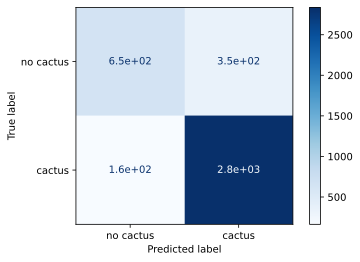

In [29]:
plot_confusion_matrix(nfnb, testXfn, testY, display_labels=['no cactus', 'cactus'], cmap=plt.cm.Blues,
values_format = 'd')

From the plot, we could see that FPR is around 35%, and TPR is around 94.6%. This classifier also have better ability in detecting cactus in image than classifying no-cactus image, but its performance on no-cactus image is better than that of Random Forest, while its performance in classification on image with cactus is slightly lower.

Next, we visualize the pictures classified wrong.

Text(0.5, 1.0, 'misclassified images')

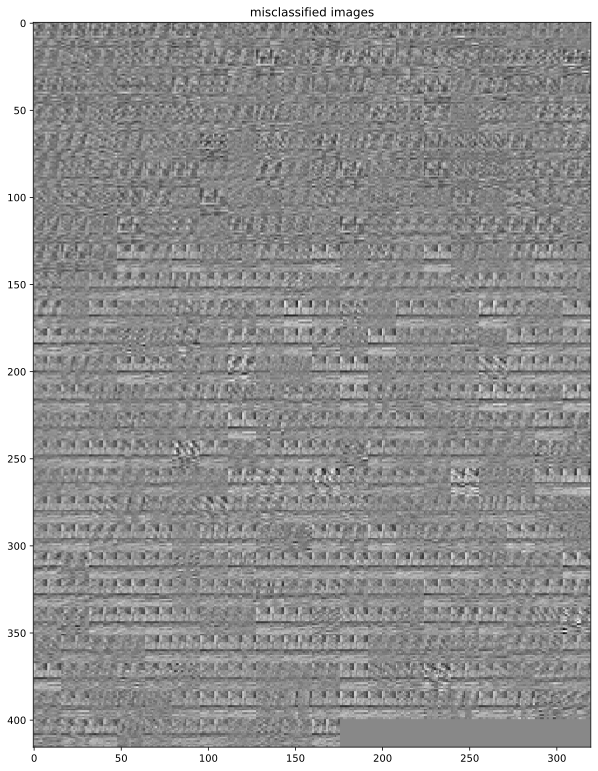

In [52]:
# find misclassified test images
inds = where(pred_nfnb != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testXfn[inds], imsize=(16,16))

# find correctly classified test images
inds = where(pred_nfnb == testY)
goodimgs = image_montage(testXfn[inds], imsize=(16,16))
    
plt.figure(figsize=(10,15))
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified images')

However, the images are blur and hard for human-eye to recognize. This is caused by the feature extraction.

### 5.3 Convoluntional Neural Network <a id="section_5_3"></a>

#### 5.3.1 Model description

There are many types of neural network, convolutional neural network is the one we used for the project. It is a sequence of convolution layers interspersed with activation functions. In our implementation, we were inspired by the original research VIGIA[2] and another person's work from the GitHub[3]. We have built the model based on them and modified implementation significantly for our project. The references are listed in the reference section.

Our model details are shown below.

#### 5.3.2 Model implementation

First, we restore the training and testing image data into the shape of (32, 32, 3) as we flattened the image array for normalization at the beginning. 

In [63]:
train_x = reshape(trainXn_NN, (len(trainXn_NN), 32, 32, 3))
test_x = reshape(testXn_NN, (4000, 32, 32, 3))

Next, we determine some key items and procedures in our CNN. 

|Specific|Value|Reason|
|:---|:---|:---|
|Activation|elu|Empirically, it yields higher result.|
|Output activation|sigmoid|Follows the standard and the classification is a binary class problem|
|Dropout|0.8|As a typical dropout probability 0.8 is usually chosen.|
|Optimizer|Adam|Standard optimizer with the best performance|
|Learning rate|0.0007|From many trails|

Despite the above listing specific, we also used Batch Normalization in our CNN. It can help to adjust activations to lie within a desired operating range, while maintaining the relative values.

In [64]:
dropout_dense_layer = 0.8

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [65]:
model.compile(optimizer = Adam(lr = .0007),
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
             )

We define the model fit process to include a validation split of 0.2. This will split 20% of the training data as the validation data while the remaining part serve as the training. Despite that, we also set the shuffle to be True, so that the training process is more robust. Then we print the accuracy.

In [66]:
history = model.fit(x=train_x,
          y=trainY,
          epochs=100,
          validation_split=0.2,
          shuffle=True,
          )

Epoch 1/100
438/438 [==============================] - 42s 96ms/step - loss: 0.9080 - accuracy: 0.9526 - val_loss: 1.2826 - val_accuracy: 0.9074
Epoch 2/100
438/438 [==============================] - 43s 99ms/step - loss: 0.3129 - accuracy: 0.9747 - val_loss: 0.3309 - val_accuracy: 0.9694
Epoch 3/100
438/438 [==============================] - 42s 96ms/step - loss: 0.0881 - accuracy: 0.9889 - val_loss: 0.3550 - val_accuracy: 0.9500
Epoch 4/100
438/438 [==============================] - 42s 97ms/step - loss: 0.0510 - accuracy: 0.9929 - val_loss: 0.4634 - val_accuracy: 0.9600
Epoch 5/100
438/438 [==============================] - 40s 92ms/step - loss: 0.0666 - accuracy: 0.9941 - val_loss: 2.3930 - val_accuracy: 0.9166
Epoch 6/100
438/438 [==============================] - 40s 91ms/step - loss: 0.0485 - accuracy: 0.9948 - val_loss: 0.3272 - val_accuracy: 0.9786
Epoch 7/100
438/438 [==============================] - 40s 91ms/step - loss: 0.0560 - accuracy: 0.9954 - val_loss: 1.6614 - val_ac

438/438 [==============================] - 40s 91ms/step - loss: 0.0143 - accuracy: 0.9996 - val_loss: 0.1389 - val_accuracy: 0.9991
Epoch 58/100
438/438 [==============================] - 40s 92ms/step - loss: 0.0313 - accuracy: 0.9996 - val_loss: 0.5951 - val_accuracy: 0.9969
Epoch 59/100
438/438 [==============================] - 39s 90ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.3693 - val_accuracy: 0.9983
Epoch 60/100
438/438 [==============================] - 40s 92ms/step - loss: 0.0751 - accuracy: 0.9988 - val_loss: 1.9524 - val_accuracy: 0.9900
Epoch 61/100
438/438 [==============================] - 39s 90ms/step - loss: 0.0494 - accuracy: 0.9994 - val_loss: 0.3982 - val_accuracy: 0.9974
Epoch 62/100
438/438 [==============================] - 40s 91ms/step - loss: 0.0161 - accuracy: 0.9999 - val_loss: 1.5597 - val_accuracy: 0.9874
Epoch 63/100
438/438 [==============================] - 41s 93ms/step - loss: 0.0066 - accuracy: 0.9999 - val_loss: 0.7601 - val_accuracy

In [67]:
test_Y = model.predict(test_x).flatten()
test_Y = [int(x) for x in test_Y]
metrics.accuracy_score(testY, test_Y) 

0.999

As you can see from the testing accuracy, the CNN model we built yield the result of 99.9%, which is higher than all other base models we considered in previous sections. Actually, when we set the random seed after importing keras, the accuracy rate would change almost every time when we rerun the model. Moreover, the accuracy rate shown from the google colab and/or localhost is different from that of kaggle, although we used the same model. The deviation usually ranges from 99.0% to 99.9%, with some occasional huge variation. However, after we set the random seed before the library loading, we get a relatively stable result with minor deviation.

#### 5.3.3 Result analysis

To analyze the result, we plot the model accuracy and loss change along the epochs.

As you can see from the below chart, the validation accuracy deviate a lot around the first 40 epochs. After that, the accuracy start to converge to the training accuracy. The trend suggests that the model is neither overfitting nor underfitting.

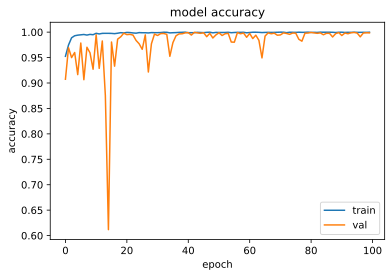

In [70]:
# model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

As for the plot of model loss, it shows a similar pattern as model accuracy. However, the convergence is not that satisfying as that of the model accuracy.

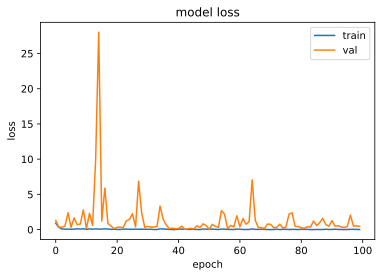

In [72]:
# model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Although from our plot, it may seem that it is not necessary to train the whole 100 epochs as the fluctuation of both validation curves become bounded some points before the 100 epochs. However, we have tried to use early stopping or less epochs to train the model, but the result is not as good as this version.

## 6. Comparison <a id="chapter6"></a>

From the above analysis, we can conclude that deep learning technique outperforms the traditional ones. From the perspective of testing accuracy, convolutional neural network yields the highest accuracy of 99.9%. In contrast, among the base models we chose, the highest one is just 88%. On the other hand, the processing time for the traditional methods deviate on whether implementing complicated dimensionality reduction algorithms. The time ranging from < 1 min to several hours. For CNN, the time complexity ranging from 4 mins to 60 mins, which depends on the usage of GPU. A detailed comparison table is shown below.

|Model with best setting|Accuracy|Processing time|
|:---|:---|:---|
|Random Forest|88%|~4 mins
|Naive Bayes|87.225%|~9s
|CNN|99.75%|~4 mins (using GPU)|
|CNN|99.9%|~60 mins (without GPU)|

## 7. Conclusion <a id="chapter7"></a>

In this project, we discussed and selected proper algorithms and techniques to be applied. Then, a large number of experiments has been conducted, among all different combinations of data-representations, models, and dimensionality reduction techniques. There were 4 different data-representations, 6 traditional models, and 5 dimensionality reduction techniques. After that, the two models, Random Forest and Naive Bayes, which returned the highest testing accuracy in the group of discriminative and probabilistic classifiers, respectively, has been selected and presented in the main body of this report. The others are attached into the Appendix. 

However, as the accuracy of traditional methods remains lower than 0.9, we decided to write Convolutional Neural Network after the presentation to try to find a better way of classification. The CNN performed well, with testing accuracy ranging from 0.99 to 0.999. 

## 8. Reference <a id="chapter8"></a>

[1] Jaitley, U. (2019, April 09). Why Data Normalization is necessary for Machine Learning models. Retrieved from https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029

[2] López-Jiménez, Efren, Vasquez-Gomez, Juan Irving, Sanchez-Acevedo, Miguel Angel, Herrera-Lozada, Juan Carlos, & Uriarte-Arcia, Abril Valeria. (2019). Columnar cactus recognition in aerial images using a deep learning approach. Ecological Informatics, 52, 131–138. https://doi.org/10.1016/j.ecoinf.2019.05.005

[3] Ahsan Khan. (2019). Aerial-_Cactus_Image_Classification. Retrieved from https://github.com/cse-ahsankhan/Aerial-_Cactus_Image_Classification/blob/master/Kaggle%20-%20Aerial%20Cactus%20identification.ipynb 

[4] Kede Ma & TAs. (2020). CS4487 Lecture notes and tutorials.

## 9. Appendix <a id="chapter9"></a>

#### Appendix I. SVM data preparation

For Kernel Support Vector Machine, as we observed in preliminary experiments, if we conduct the training and testing using all data in the given dataset, the running time becomes terribly long (more than 24 hours). 

The reason of such long running time is that in our Kernel SVM, it is computationally expensive to do cross-validation. To calculate the kernel matrix, there will be M^2 terms, where M denotes the size of the training set. In this project, M = 17,500, and M^2 = 306,250,000. This is too large and the running time becomes too long.

To reduce the running time, the data has been subsampled into 1/4 such that M^2 got significantly reduced. By doing this, combined with the smaller set of ns for cross-validation, which will be shown later in the codes for the models, we are now able to run through the SVM and see its results.

In [ ]:
# for mac
imgdata_SVM = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

loadme=True
train_subsample = 4
train_counter = [0, 0]
test_counter = [0, 0]

# load the zip file
filename = 'data.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "data/training_set/training_set/*/*.jpg"):
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (cactus, no_cactus)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = cactus; class 0 = no cactus
        myclass = int(fclass == "cactus") 

        loadme = False
        if (train_counter[myclass] % train_subsample) == 0:
              loadme = True
        train_counter[myclass] += 1
       
        if (loadme):
            myfile = zfile.open(name)
            img = matplotlib.image.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            img = resize(img, (32, 32), preserve_range=True, anti_aliasing=True)
            myfile.close()

          # append data
            imgdata_SVM['train'].append(img)
            classes['train'].append(myclass)
    elif fnmatch.fnmatch(name, "data/validation_set/validation_set/*/*.jpg"):
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (cactus, no_cactus)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        
        myclass = int(fclass == "cactus")  

        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        # convert to grayscale
        img = skimage.color.rgb2gray(img)
        img = resize(img, (32, 32), preserve_range=True, anti_aliasing=True)
        myfile.close()

        # append data
        imgdata_SVM['test'].append(img)
        classes['test'].append(myclass)
        
zfile.close()
imgsize = img.shape

print(len(imgdata_SVM['train']))
print(len(imgdata_SVM['test']))
trainclass2start = sum(classes['train'])

In [ ]:
trainX_SVM = empty((len(imgdata_SVM['train']), prod(imgsize)))
for i,img in enumerate(imgdata_SVM['train']):
    trainX_SVM[i,:] = ravel(img)
trainY_SVM = asarray(classes['train'])  # convert list to numpy array
print(trainX_SVM.shape)
print(trainY_SVM.shape)

testX_SVM = empty((len(imgdata_SVM['test']), prod(imgsize)))
for i,img in enumerate(imgdata_SVM['test']):
    testX_SVM[i,:] = ravel(img)
testY_SVM = asarray(classes['test'])  # convert list to numpy array
print(testX_SVM.shape)
print(testY_SVM.shape)## 1. Pre-processingAppendix II. Models we tried in the preliminary experiment

In [ ]:
trainXn_SVM, testXn_SVM = norm(trainX_SVM, testX_SVM)
trainXf_SVM = extract_features(imgdata_SVM['train'])
print(trainXf_SVM.shape)
testXf_SVM = extract_features(imgdata_SVM['test'])
print(testXf_SVM.shape)
trainXfn_SVM, testXfn_SVM = norm(trainXf_SVM, testXf_SVM)

#### Appendix II. Models we tried in the preliminary experiment

In [ ]:
def LR():
    return linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)

In [ ]:
# setup all the parameters and models
exps = {
    'svm-rbf': {
        'paramgrid': {'base_estimator__C': logspace(-2,3,10), 'base_estimator__gamma': logspace(-4,3,10) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'base_estimator__C': logspace(-2,3,10), 'base_estimator__degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },
}

In [ ]:
def SVM(m_type):
    return model_selection.GridSearchCV(BaggingClassifier(exps[m_type]['clf'], n_jobs =-1), 
                                        param_grid = exps[m_type]['paramgrid'])

In [ ]:
def KNN():
    paramgrid = {'n_neighbors': [3,5,7]}
    clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=paramgrid, cv=10, n_jobs=-1)
    return clf

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def LDA():
    lda = LinearDiscriminantAnalysis()
    paramgrid = {'solver': ['svd','lsqr','eigen']}
    clf = model_selection.GridSearchCV(lda, param_grid=paramgrid, cv=10)
    return clf

At the beginning, we did not considered error analysis, and the definition of the dimensionality reduction functions are different from the final version (as shown in the main body). Here we show the codes for the previous version, as we would like to present the results we got in priliminary experiments.

In [ ]:
def pca_func(trainX, testX, trainY, testY, model):
    trainacc = []
    testacc = []
    for i in ns:
        pca = decomposition.PCA(n_components = i).fit(trainX)
        trainXn = pca.transform(trainX)
        testXn = pca.transform(testX)
        m = model.fit(trainXn, trainY)
        trainacc.append(metrics.accuracy_score(trainY, m.predict(trainXn)))
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return trainXn, testXn, trainacc, testacc

def svd_func(trainX, testX, trainY, testY, model):
    trainacc = []
    testacc = []
    for i in ns:
        svd = decomposition.TruncatedSVD(n_components=i).fit(trainX)
        trainXn = svd.transform(trainX)
        testXn = svd.transform(testX)
        m = model.fit(trainXn, trainY)
        trainacc.append(metrics.accuracy_score(trainY, m.predict(trainXn)))
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return trainXn, testXn, trainacc, testacc

def kpca_rbf_func(trainX, testX, trainY, testY, model):
    trainacc = []
    testacc = []
    for i in ns:
        kpca = decomposition.KernelPCA(n_components=i, kernel='rbf',n_jobs=-1).fit(trainX)
        trainXn = kpca.transform(trainX)
        testXn = kpca.transform(testX)
        m = model.fit(trainXn, trainY)
        trainacc.append(metrics.accuracy_score(trainY, m.predict(trainXn)))
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return trainXn, testXn, trainacc, testacc

def kpca_poly_func(trainX, testX, trainY, testY, model):
    trainacc = []
    testacc = []
    for i in ns:
        kpca = decomposition.KernelPCA(n_components=i, kernel='poly',n_jobs=-1).fit(trainX)
        trainXn = kpca.transform(trainX)
        testXn = kpca.transform(testX)
        m = model.fit(trainXn, trainY)
        trainacc.append(metrics.accuracy_score(trainY, m.predict(trainXn)))
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return trainXn, testXn, trainacc, testacc

def ica_func(trainX, testX, trainY, testY, model):
    trainacc = []
    testacc = []
    for i in ns:
        ica = decomposition.FastICA(n_components=i).fit(trainX)
        trainXn = ica.transform(trainX)
        testXn = ica.transform(testX)
        m = model.fit(trainXn, trainY)
        trainacc.append(metrics.accuracy_score(trainY, m.predict(trainXn)))
        testacc.append(metrics.accuracy_score(testY, m.predict(testXn)))
    return trainXn, testXn, trainacc, testacc#### Appendix II. Models we tried in the preliminary experiment

#### Appendix III. Training and Testing

Because of same reasons, smaller range of ns has been applied to Logistic Regression and Support Vector Machine.

Logistic Regression:

In [ ]:
ns = [20,25,30]

In [ ]:
lr = LR().fit(trainX, trainY)
trainAcc = metrics.accuracy_score(trainY, lr.predict(trainX))
testAcc = metrics.accuracy_score(testY, lr.predict(testX))
print(f'Logistic Regression Train Accuracy: {trainAcc}')
print(f'Logistic Regression Test Accuracy : {testAcc}')

Logistic Regression Train Accuracy: 0.8201714285714286
Logistic Regression Test Accuracy : 0.79375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
nlr = LR().fit(trainXn, trainY)
trainAcc = metrics.accuracy_score(trainY, nlr.predict(trainXn))
testAcc = metrics.accuracy_score(testY, nlr.predict(testXn))
print(f'Logistic Regression Train Accuracy: {trainAcc}')
print(f'Logistic Regression Test Accuracy : {testAcc}')

Logistic Regression Train Accuracy: 0.8223428571428572
Logistic Regression Test Accuracy : 0.7945


In [ ]:
flr = LR().fit(trainXf, trainY)
trainAcc = metrics.accuracy_score(trainY, flr.predict(trainXf))
testAcc = metrics.accuracy_score(testY, flr.predict(testXf))
print(f'Logistic Regression Train Accuracy: {trainAcc}')
print(f'Logistic Regression Test Accuracy : {testAcc}')

Logistic Regression Train Accuracy: 0.8160571428571428
Logistic Regression Test Accuracy : 0.793


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
nflr = LR().fit(trainXfn, trainY)
trainAcc = metrics.accuracy_score(trainY, nflr.predict(trainXfn))
testAcc = metrics.accuracy_score(testY, nflr.predict(testXfn))
print(f'Logistic Regression Train Accuracy: {trainAcc}')
print(f'Logistic Regression Test Accuracy : {testAcc}')

Logistic Regression Train Accuracy: 0.8148
Logistic Regression Test Accuracy : 0.79175


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainX, testX, trainY, testY, LR())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')

train, test, trainacc, testacc_svd = svd_func(trainX, testX, trainY, testY, LR())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')

train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainX, testX, trainY, testY, LR())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')

train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainX, testX, trainY, testY, LR())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')

train, test, trainacc, testacc_ica = ica_func(trainX, testX, trainY, testY, LR())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 20
Best test accuracy: 0.79875
----------SVD----------
Best number of components: 20
Best test accuracy: 0.79875
----------KPCA_rbf----------
Best number of components: 25
Best test accuracy: 0.80725
----------KPCA_poly----------
Best number of components: 25
Best test accuracy: 0.80125
----------ICA----------
Best number of components: 20
Best test accuracy: 0.7995


In [ ]:
train, test, trainacc, testacc_ica = ica_func(trainXn, testXn, trainY, testY, LR())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

train, test, trainacc, testacc_svd = svd_func(trainXn, testXn, trainY, testY, LR())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')

train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXn, testXn, trainY, testY, LR())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')

train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXn, testXn, trainY, testY, LR())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')

train, test, trainacc, testacc_ica = ica_func(trainXn, testXn, trainY, testY, LR())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------ICA----------
Best number of components: 20
Best test accuracy: 0.79975
----------SVD----------
Best number of components: 20
Best test accuracy: 0.79825
----------KPCA_rbf----------
Best number of components: 25
Best test accuracy: 0.81975
----------KPCA_poly----------
Best number of components: 25
Best test accuracy: 0.79925
----------ICA----------
Best number of components: 20
Best test accuracy: 0.79975


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXf, testXf, trainY, testY, LR())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')

train, test, trainacc, testacc_svd = svd_func(trainXf, testXf, trainY, testY, LR())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')

train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXf, testXf, trainY, testY, LR())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')

train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXf, testXf, trainY, testY, LR())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')

train, test, trainacc, testacc_ica = ica_func(trainXf, testXf, trainY, testY, LR())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 25
Best test accuracy: 0.79975
----------SVD----------
Best number of components: 25
Best test accuracy: 0.79975
----------KPCA_rbf----------
Best number of components: 25
Best test accuracy: 0.8405
----------KPCA_poly----------
Best number of components: 25
Best test accuracy: 0.81325
----------ICA----------
Best number of components: 25
Best test accuracy: 0.79975


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXfn, testXfn, trainY, testY, LR())
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')

train, test, trainacc, testacc_svd = svd_func(trainXfn, testXfn, trainY, testY, LR())
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')

train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXfn, testXfn, trainY, testY, LR())
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')

train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXfn, testXfn, trainY, testY, LR())
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')

train, test, trainacc, testacc_ica = ica_func(trainXfn, testXfn, trainY, testY, LR())
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 30
Best test accuracy: 0.80075
----------SVD----------
Best number of components: 30
Best test accuracy: 0.8005
----------KPCA_rbf----------
Best number of components: 25
Best test accuracy: 0.80975
----------KPCA_poly----------
Best number of components: 20
Best test accuracy: 0.7995
----------ICA----------
Best number of components: 30
Best test accuracy: 0.8015


Kernel Support Vector Machine:

In [ ]:
svm_RBF = SVM('svm-rbf').fit(trainX_SVM, trainY_SVM)
svm_POLY = SVM('svm-poly').fit(trainX_SVM, trainY_SVM)
train_rbf = metrics.accuracy_score(trainY_SVM, svm_RBF.predict(trainX_SVM))
test_rbf = metrics.accuracy_score(testY_SVM, svm_RBF.predict(testX_SVM))
train_poly = metrics.accuracy_score(trainY_SVM, svm_POLY.predict(trainX_SVM))
test_poly = metrics.accuracy_score(testY_SVM, svm_POLY.predict(testX_SVM))
print(f'SVM-RBF Train Accuracy : {train_rbf}')
print(f'SVM-RBF Test Accuracy  : {test_rbf}')
print(f'SVM-POLY Train Accuracy: {train_poly}')
print(f'SVM-POLY Test Accuracy : {test_poly}')

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


SVM-RBF Train Accuracy : 0.9846857142857143
SVM-RBF Test Accuracy  : 0.8495
SVM-POLY Train Accuracy: 0.8594285714285714
SVM-POLY Test Accuracy : 0.81575


In [ ]:
svm_RBF = SVM('svm-rbf').fit(trainXn_SVM, trainY_SVM)
svm_POLY = SVM('svm-poly').fit(trainXn_SVM, trainY_SVM)
train_rbf = metrics.accuracy_score(trainY_SVM, svm_RBF.predict(trainXn_SVM))
test_rbf = metrics.accuracy_score(testY_SVM, svm_RBF.predict(testXn_SVM))
train_poly = metrics.accuracy_score(trainY_SVM, svm_POLY.predict(trainXn_SVM))
test_poly = metrics.accuracy_score(testY_SVM, svm_POLY.predict(testXn_SVM))
print(f'SVM-RBF Train Accuracy : {train_rbf}')
print(f'SVM-RBF Test Accuracy  : {test_rbf}')
print(f'SVM-POLY Train Accuracy: {train_poly}')
print(f'SVM-POLY Test Accuracy : {test_poly}')

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


SVM-RBF Train Accuracy : 0.984
SVM-RBF Test Accuracy  : 0.84525
SVM-POLY Train Accuracy: 0.9657142857142857
SVM-POLY Test Accuracy : 0.8375


In [ ]:
svm_RBF = SVM('svm-rbf').fit(trainXf_SVM, trainY_SVM)
svm_POLY = SVM('svm-poly').fit(trainXf_SVM, trainY_SVM)
train_rbf = metrics.accuracy_score(trainY_SVM, svm_RBF.predict(trainXf_SVM))
test_rbf = metrics.accuracy_score(testY_SVM, svm_RBF.predict(testXf_SVM))
train_poly = metrics.accuracy_score(trainY_SVM, svm_POLY.predict(trainXf_SVM))
test_poly = metrics.accuracy_score(testY_SVM, svm_POLY.predict(testXf_SVM))
print(f'SVM-RBF Train Accuracy : {train_rbf}')
print(f'SVM-RBF Test Accuracy  : {test_rbf}')
print(f'SVM-POLY Train Accuracy: {train_poly}')
print(f'SVM-POLY Test Accuracy : {test_poly}')

SVM-RBF Train Accuracy : 0.9664
SVM-RBF Test Accuracy  : 0.8515
SVM-POLY Train Accuracy: 0.904
SVM-POLY Test Accuracy : 0.84025


In [ ]:
svm_RBF = SVM('svm-rbf').fit(trainXfn_SVM, trainY_SVM)
svm_POLY = SVM('svm-poly').fit(trainXfn_SVM, trainY_SVM)
train_rbf = metrics.accuracy_score(trainY_SVM, svm_RBF.predict(trainXfn_SVM))
test_rbf = metrics.accuracy_score(testY_SVM, svm_RBF.predict(testXfn_SVM))
train_poly = metrics.accuracy_score(trainY_SVM, svm_POLY.predict(trainXfn_SVM))
test_poly = metrics.accuracy_score(testY_SVM, svm_POLY.predict(testXfn_SVM))
print(f'SVM-RBF Train Accuracy : {train_rbf}')
print(f'SVM-RBF Test Accuracy  : {test_rbf}')
print(f'SVM-POLY Train Accuracy: {train_poly}')
print(f'SVM-POLY Test Accuracy : {test_poly}')

SVM-RBF Train Accuracy : 0.9821714285714286
SVM-RBF Test Accuracy  : 0.81575
SVM-POLY Train Accuracy: 0.9334857142857143
SVM-POLY Test Accuracy : 0.80525


Because of the computation being too expensive for SVM with some dimensionality reduction techniques, we only run the linear dimensionality reductions.

In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainX_SVM, testX_SVM, trainY_SVM, testY_SVM, SVM('svm-rbf'))
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')

train, test, trainacc, testacc_svd = svd_func(trainX_SVM, testX_SVM, trainY_SVM, testY_SVM, SVM('svm-rbf'))
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')

----------PCA----------
Best number of components: 30
Best test accuracy: 0.85925
----------SVD----------
Best number of components: 25
Best test accuracy: 0.8445


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXn_SVM, testXn_SVM, trainY_SVM, testY_SVM, SVM('svm-rbf'))
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')

train, test, trainacc, testacc_svd = svd_func(trainXn_SVM, testXn_SVM, trainY_SVM, testY_SVM, SVM('svm-rbf'))
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')

----------PCA----------
Best number of components: 25
Best test accuracy: 0.84475
----------SVD----------
Best number of components: 30
Best test accuracy: 0.8605


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXf_SVM, testXf_SVM, trainY_SVM, testY_SVM, SVM('svm-rbf'))
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')

train, test, trainacc, testacc_svd = svd_func(trainXf_SVM, testXf_SVM, trainY_SVM, testY_SVM, SVM('svm-rbf'))
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')

----------PCA----------
Best number of components: 30
Best test accuracy: 0.866
----------SVD----------
Best number of components: 30
Best test accuracy: 0.85025


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXfn_SVM, testXfn_SVM, trainY_SVM, testY_SVM, SVM('svm-rbf'))
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')

train, test, trainacc, testacc_svd = svd_func(trainXfn_SVM, testXfn_SVM, trainY_SVM, testY_SVM, SVM('svm-rbf'))
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')

----------PCA----------
Best number of components: 25
Best test accuracy: 0.8465
----------SVD----------
Best number of components: 30
Best test accuracy: 0.8505


For KNN and LDA, the ns is same as the (larger) one for Naive Bayes.

K-Nearest Neighbors:

In [ ]:
ns = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

In [ ]:
knn = KNN().fit(trainX,trainY)

In [ ]:
print(knn.score(testX,testY))

0.46825


In [ ]:
nknn = KNN().fit(trainXn,trainY)

In [ ]:
print(nknn.score(testXn,testY))

0.46725


In [ ]:
fknn = KNN().fit(trainXf,trainY)

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print(fknn.score(testXf,testY))

0.77675


In [ ]:
nfknn = KNN().fit(trainXfn,trainY)

In [ ]:
print(nfknn.score(testXfn,testY))

0.7845


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainX, testX, trainY, testY, KNN())
train, test, trainacc, testacc_svd = svd_func(trainX, testX, trainY, testY, KNN())
train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainX, testX, trainY, testY, KNN())
train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainX, testX, trainY, testY, KNN())
train, test, trainacc, testacc_ica = ica_func(trainX, testX, trainY, testY, KNN())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


In [ ]:
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 10
Best test accuracy: 0.8475
----------SVD----------
Best number of components: 10
Best test accuracy: 0.84825
----------KPCA_rbf----------
Best number of components: 10
Best test accuracy: 0.84375
----------KPCA_poly----------
Best number of components: 10
Best test accuracy: 0.8515
----------ICA----------
Best number of components: 10
Best test accuracy: 0.84525


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXn, testXn, trainY, testY, KNN())
train, test, trainacc, testacc_svd = svd_func(trainXn, testXn, trainY, testY, KNN())
train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXn, testXn, trainY, testY, KNN())
train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXn, testXn, trainY, testY, KNN())
train, test, trainacc, testacc_ica = ica_func(trainXn, testXn, trainY, testY, KNN())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


In [ ]:
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 10
Best test accuracy: 0.85075
----------SVD----------
Best number of components: 10
Best test accuracy: 0.845
----------KPCA_rbf----------
Best number of components: 10
Best test accuracy: 0.8475
----------KPCA_poly----------
Best number of components: 10
Best test accuracy: 0.84625
----------ICA----------
Best number of components: 10
Best test accuracy: 0.84625


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXf, testXf, trainY, testY, KNN())
train, test, trainacc, testacc_svd = svd_func(trainXf, testXf, trainY, testY, KNN())
train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXf, testXf, trainY, testY, KNN())
train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXf, testXf, trainY, testY, KNN())
train, test, trainacc, testacc_ica = ica_func(trainXf, testXf, trainY, testY, KNN())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


In [ ]:
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 5
Best test accuracy: 0.837
----------SVD----------
Best number of components: 5
Best test accuracy: 0.8355
----------KPCA_rbf----------
Best number of components: 40
Best test accuracy: 0.83675
----------KPCA_poly----------
Best number of components: 10
Best test accuracy: 0.83925
----------ICA----------
Best number of components: 5
Best test accuracy: 0.8335


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXfn, testXfn, trainY, testY, KNN())
train, test, trainacc, testacc_svd = svd_func(trainXfn, testXfn, trainY, testY, KNN())
train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXfn, testXfn, trainY, testY, KNN())
train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXfn, testXfn, trainY, testY, KNN())
train, test, trainacc, testacc_ica = ica_func(trainXfn, testXfn, trainY, testY, KNN())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


In [ ]:
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 10
Best test accuracy: 0.84475
----------SVD----------
Best number of components: 10
Best test accuracy: 0.8435
----------KPCA_rbf----------
Best number of components: 10
Best test accuracy: 0.8455
----------KPCA_poly----------
Best number of components: 10
Best test accuracy: 0.84225
----------ICA----------
Best number of components: 10
Best test accuracy: 0.8345


Linear Discriminant Analysis:

In [ ]:
lda = LDA().fit(trainX,trainY)

In [ ]:
print(lda.score(testX,testY))

0.80075


In [ ]:
nlda = LDA().fit(trainXn,trainY)

In [ ]:
print(nlda.score(testXn,testY))

0.80075


In [ ]:
flda = LDA().fit(trainXf,trainY)

In [ ]:
print(flda.score(testXf,testY))

0.79875


In [ ]:
nflda = LDA().fit(trainXfn,trainY)

In [ ]:
print(nflda.score(testXfn,testY))

0.79875


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainX, testX, trainY, testY, LDA())
train, test, trainacc, testacc_svd = svd_func(trainX, testX, trainY, testY, LDA())
train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainX, testX, trainY, testY, LDA())
train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainX, testX, trainY, testY, LDA())
train, test, trainacc, testacc_ica = ica_func(trainX, testX, trainY, testY, LDA())

In [ ]:
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 25
Best test accuracy: 0.8055
----------SVD----------
Best number of components: 25
Best test accuracy: 0.80525
----------KPCA_rbf----------
Best number of components: 25
Best test accuracy: 0.81225
----------KPCA_poly----------
Best number of components: 45
Best test accuracy: 0.81
----------ICA----------
Best number of components: 25
Best test accuracy: 0.80525


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXn, testXn, trainY, testY, LDA())
train, test, trainacc, testacc_svd = svd_func(trainXn, testXn, trainY, testY, LDA())
train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXn, testXn, trainY, testY, LDA())
train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXn, testXn, trainY, testY, LDA())
train, test, trainacc, testacc_ica = ica_func(trainXn, testXn, trainY, testY, LDA())

In [ ]:
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 25
Best test accuracy: 0.80525
----------SVD----------
Best number of components: 15
Best test accuracy: 0.80625
----------KPCA_rbf----------
Best number of components: 80
Best test accuracy: 0.84
----------KPCA_poly----------
Best number of components: 25
Best test accuracy: 0.802
----------ICA----------
Best number of components: 25
Best test accuracy: 0.8055


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXf, testXf, trainY, testY, LDA())
train, test, trainacc, testacc_svd = svd_func(trainXf, testXf, trainY, testY, LDA())
train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXf, testXf, trainY, testY, LDA())
train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXf, testXf, trainY, testY, LDA())
train, test, trainacc, testacc_ica = ica_func(trainXf, testXf, trainY, testY, LDA())

In [ ]:
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 35
Best test accuracy: 0.8035
----------SVD----------
Best number of components: 35
Best test accuracy: 0.8035
----------KPCA_rbf----------
Best number of components: 85
Best test accuracy: 0.8155
----------KPCA_poly----------
Best number of components: 60
Best test accuracy: 0.8285
----------ICA----------
Best number of components: 35
Best test accuracy: 0.8035


In [ ]:
train, test, trainacc, testacc_pca = pca_func(trainXfn, testXfn, trainY, testY, LDA())
train, test, trainacc, testacc_svd = svd_func(trainXfn, testXfn, trainY, testY, LDA())
train, test, trainacc, testacc_kpca_rbf = kpca_rbf_func(trainXfn, testXfn, trainY, testY, LDA())
train, test, trainacc, testacc_kpca_poly = kpca_poly_func(trainXfn, testXfn, trainY, testY, LDA())
train, test, trainacc, testacc_ica = ica_func(trainXfn, testXfn, trainY, testY, LDA())

In [ ]:
print("----------PCA----------")
print(f'Best number of components: {ns[testacc_pca.index(max(testacc_pca))]}')
print(f'Best test accuracy: {max(testacc_pca)}')
print("----------SVD----------")
print(f'Best number of components: {ns[testacc_svd.index(max(testacc_svd))]}')
print(f'Best test accuracy: {max(testacc_svd)}')
print("----------KPCA_rbf----------")
print(f'Best number of components: {ns[testacc_kpca_rbf.index(max(testacc_kpca_rbf))]}')
print(f'Best test accuracy: {max(testacc_kpca_rbf)}')
print("----------KPCA_poly----------")
print(f'Best number of components: {ns[testacc_kpca_poly.index(max(testacc_kpca_poly))]}')
print(f'Best test accuracy: {max(testacc_kpca_poly)}')
print("----------ICA----------")
print(f'Best number of components: {ns[testacc_ica.index(max(testacc_ica))]}')
print(f'Best test accuracy: {max(testacc_ica)}')

----------PCA----------
Best number of components: 40
Best test accuracy: 0.80625
----------SVD----------
Best number of components: 30
Best test accuracy: 0.805
----------KPCA_rbf----------
Best number of components: 90
Best test accuracy: 0.836
----------KPCA_poly----------
Best number of components: 90
Best test accuracy: 0.831
----------ICA----------
Best number of components: 40
Best test accuracy: 0.80625
